In [ ]:
#How to submit to github

#Step 1. cd evhs-covid19
#

In [1]:
#imports
import pandas
import numpy
import os
import plotnine
from plotnine.data import *
import glob
from datetime import datetime
import math
from datetime import datetime
from time import sleep

In [2]:
#Changeable constants
my_path = "..\\data\\time-series-19-covid-combined_csv.csv"
states_path = "..\\src\\state_info.csv"
country_pop_path = "..\\src\\country_info.csv"
countries_of_interest = {"Spain":[40.4637, 3.7492],"Italy":[math.nan, math.nan],\
                        "Korea, South":[math.nan, math.nan], "US":[math.nan, math.nan]} #gets the countries of interest and their latitude/longitude

In [115]:
def plotData(data, x_data, y_data, colorKey, text_size = 14, graph_w = 20, graph_h = 10):
    myPlot = plotnine.ggplot(data)\
    + plotnine.aes(x = x_data, y = y_data, color=colorKey)\
    + plotnine.geom_line()
    
    myPlot.draw()


def plotDataNumpy(data, y_axis, x_axis, ylog_scale = False, xlog_scale = False, colors = "pk pr pg py pc".split(), win = 7):    
    #smoothing out the data
    print("Checkpoint 1")
    data4 = smoothData(data6, "Country/Region", y_axis, x_axis, window = win)
    fig, ax = plt.subplots()
    print("Checkpoint 4")
    #log scales
    if ylog_scale == True:
        plt.yscale("log")
    if xlog_scale == True:
        plt.xscale("log")
    #making a legend where each country is a different color
    place = 0
    for i in set(data1["Country/Region"]):
        data5 = data4[data4["Country/Region"]==i]
        y = data5[y_axis]
        x = data5[x_axis]
        ax.plot(x, y, '-'+colors[place], label=i)
        place += 1
    plt.legend()
    #adding labels
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    #plotting
    plt.plot(x, y)
    

def combine_subsections(df, big_place, big_place_category="Country/Region", sub_place_category = "Province/State",\
                        new_big_place_name = "", new_sub_place_name = math.nan, lat = math.nan, long = math.nan,\
                        dates = [], include_actual_country=True):
    
    ret_data = pandas.DataFrame(columns = df.columns)
    if new_big_place_name == "":
        new_big_place_name = "Total Data for "+new_big_place_name #renames the country
    df2 = df[df[big_place_category]==big_place] #gets the data for the place
    
    if len(dates)==0:    
        dates = list(set(df2["Date"])) #gets the dates if they haven't been provided
    for date in dates: #iterates through each date
        #print(big_place_category, ": ", big_place, "  |  Date: ", date)
        df3 = df2[df2["Date"]==date] #gets the data for the place on that particular date 
        if include_actual_country == False:
            df3 = df3[df3[sub_place_category]==df3[sub_place_category]]
            #Both Denmark and the Faroe Islands have the country as Denmark
            #but the state for the Faroe Islands is the Faroe Islands, while the state for Denmark is nan
            #nan values don't equal themselves, so this filters out the main country
            #This logic holds for France, Britain, and the Netherlands as well

        value = [date, new_big_place_name, new_sub_place_name, lat, long, df3["Confirmed"].sum(), df3["Recovered"].sum(), \
                df3["Deaths"].sum()]
        #creates a list: [date, country, state, latitude, longitude, confirmed cases, recovered cases, deaths]
        
        value = pandas.Series(data = value, index = df3.columns) #appends the list to the dataframe
        df = df.append(value, ignore_index = True) #appends the mini-dataframe to the main one
        ret_data = ret_data.append(value, ignore_index = True)
    return df, ret_data

def rounder(number, places):
    number = int(number * (10**places))
    return number / (10**places)
    

def moving_average(values, length, rounded = 2):
    if (length > len(values) ) or (length < 0):
        return math.nan
    else:
        ret = []
        for i in range( len(values)-length+1  ):
            avg = sum(values[ i:(length+i)  ])
            ret.append(rounder(avg/length, rounded))
        return ret

def cleaningCombinedDataForCountryOnly(country, minimum = 1):
    country = country.sort_values(by = ["Date"])
    country = country.reset_index(drop = True)
    country["Active"] = country["Confirmed"] - country["Recovered"]
    country = country[country["Confirmed"]>=minimum]
    country = country.reset_index(drop = True)
    country["Days"] = country.index
    return country


def getDoublingRates(country):
    doubling_rates = []
    doubling_rates.append(math.nan)
    for i in range(len(country)-1):
        rate = 2 * country.iloc[i]["Confirmed"] / (country.iloc[i+1]["Confirmed"] - country.iloc[i]["Confirmed"])
        rate = min(10**11, rate)
        if rate < 10**10:
            rate = rounder(rate, 3)
        else:
            rate = math.nan
        doubling_rates.append(rate)
    country["Days until Cases Double (at this Rate)"] = doubling_rates
    return country



def smoothData(data, var1, var2, var3, window = 7):
    data7 = pandas.DataFrame()
    print("Checkpoint 2")
    for i in list(set(data[var1])):
        data2 = data[data[var1]==i]
        data3 = data2[[var1, var2, var3]]
        data3 = data3[data3[var2]==data3[var2]]
        data4 = data3[var2].rolling(window).mean()
        data5 = data3[var3].rolling(window).mean()
        data6 = pandas.DataFrame()
        data6[var2] = data4
        data6[var3] = data5
        data6[var1] = i
        data7 = data7.append(data6)
        print(i)
    print("Checkpoint 3")
    return data7

def smoothAndPlotData(data, x, y, color, myWindow = 1):
    data2 = data[[x, y, color]]
    data2 = smoothData(data2, color, y, x, window = myWindow)
    plotData(data2, x, y, color)   

def addNewCases(mydata):
    place = 0
    country = mydata.iloc[0]["Country/Region"]
    country_places = [0]
    for i in range(1, len(mydata)):
        if mydata.iloc[i]["Country/Region"] != country:
            country_places.append(i)
            country = mydata.iloc[i]["Country/Region"]
        place += 1
    mydata["New Cases"] = numpy.nan
    my_columns = mydata.columns
    mydata = numpy.array(mydata)
    for i in country_places:
        mydata[i][-1] = mydata[i][-4]
    for i in range(1, len(mydata)):
        if mydata[i][-1] != mydata[i][-1]:
            mydata[i][-1] = mydata[i][-4] - mydata[i-1][-4] + mydata[i][-6] - mydata[i-1][-6]
    mydata = pandas.DataFrame(mydata, columns = my_columns)

    mydata[["New Cases", "Days since First Infection", "Confirmed", "Deaths", "Active"]] = \
    mydata[["New Cases", "Days since First Infection", "Confirmed", "Deaths", "Active"]].apply(pandas.to_numeric)
    return mydata

C:\Users\bhata\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\bhata\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 6 rows containing missing values.
  warn(msg.format(n1-n2))


            Date Country/Region Province/State      Lat     Long  Confirmed  \
8299  2020-04-13        Denmark            NaN  56.2639   9.5018     6318.0   
8382  2020-04-13        Denmark  Faroe Islands  61.8926  -6.9118      184.0   
8465  2020-04-13        Denmark      Greenland  71.7069 -42.6043       11.0   

      Recovered  Deaths  
8299     2235.0   285.0  
8382      157.0     0.0  
8465       11.0     0.0  
6513.0


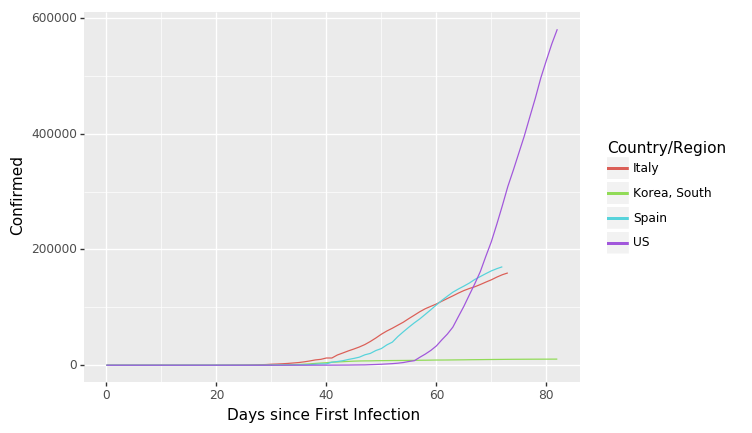

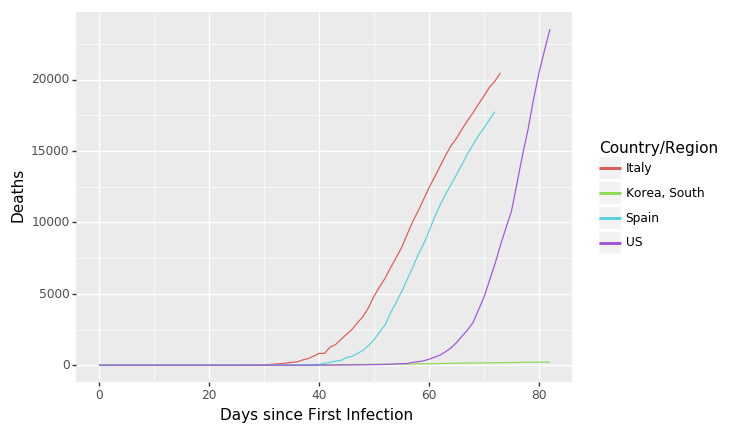

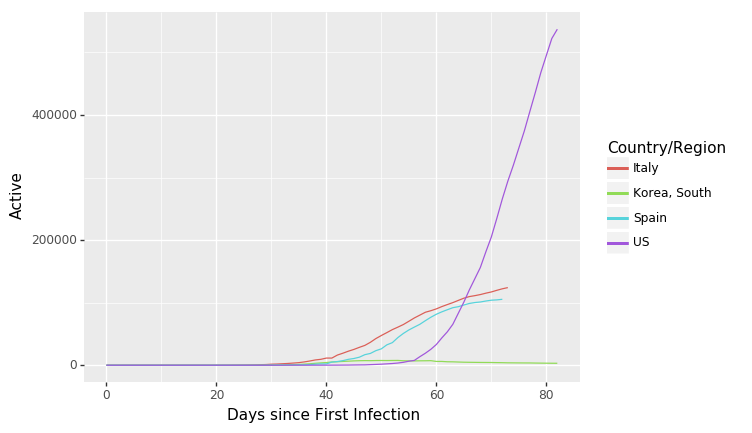

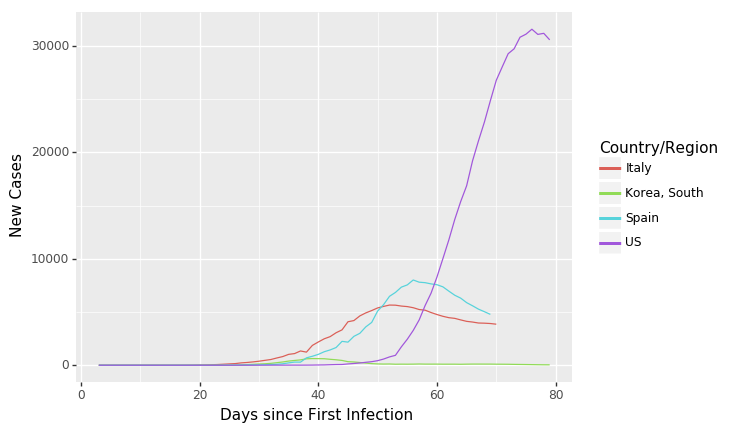

In [4]:
OGdata = pandas.read_csv(my_path) #reads the csv file
data1 = pandas.DataFrame()


for i in countries_of_interest:
    #gets the information for a particular country, cleans it, and appends it to the data1 dataframe
    x, country = combine_subsections(OGdata, big_place = i, new_big_place_name = i, \
                                    lat = countries_of_interest[i][0], long = countries_of_interest[i][1])
    
    
    country = cleaningCombinedDataForCountryOnly(country)
    country = getDoublingRates(country)
    data1 = data1.append(country)

data1.rename(columns = {"Days":"Days since First Infection"}, inplace = True)
data1 = addNewCases(data1)

smoothAndPlotData(data1, "Days since First Infection", "Confirmed", "Country/Region")
smoothAndPlotData(data1, "Days since First Infection", "Deaths", "Country/Region")
smoothAndPlotData(data1, "Days since First Infection", "Active", "Country/Region")
smoothAndPlotData(data1, "Days since First Infection", "New Cases", "Country/Region", 7)
#x, France = combine_subsections(OGdata, "France", "France", "")


a = OGdata[OGdata["Country/Region"]=="Denmark"]
print(a[a["Date"]=="2020-04-13"])
print(a[a["Date"]=="2020-04-13"]["Confirmed"].sum())

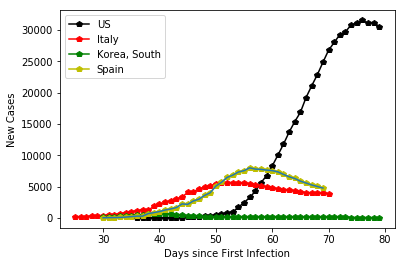

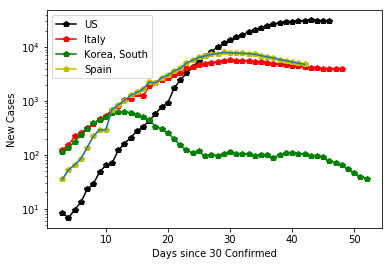

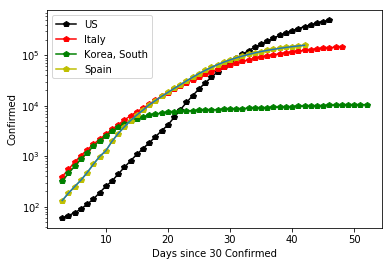

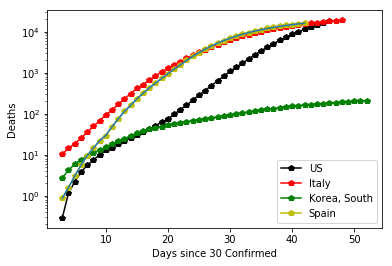

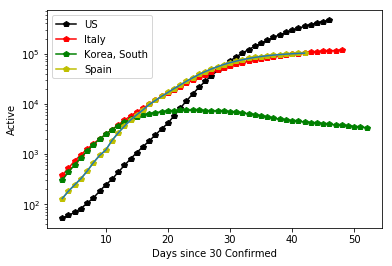

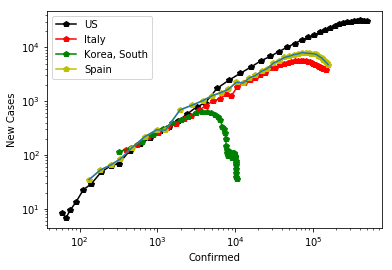

In [5]:
import matplotlib.pyplot as plt

filtering_criterion = "Confirmed"
minimum = 30
maximum = 1000000
data3 = data1[data1[filtering_criterion]>minimum]
data3 = data3[data3[filtering_criterion]<maximum]

data6 = pandas.DataFrame()
for i in set(data3["Country/Region"]):
    #gets the information for a particular country, cleans it, and appends it to the data1 dataframe
    country = data3[data3["Country/Region"]==i]
    country = cleaningCombinedDataForCountryOnly(country)
    data6 = data6.append(country)

graphedDays = "Days since "+str(minimum)+" "+filtering_criterion
data6 = data6.rename(columns = {"Days":graphedDays})
plotDataNumpy(data6, "New Cases", "Days since First Infection", False, win = 7)
plotDataNumpy(data6, "New Cases", graphedDays, True, win = 7)
plotDataNumpy(data6, "Confirmed", graphedDays, True, win = 7)
plotDataNumpy(data6, "Deaths", graphedDays, True, win = 7)
plotDataNumpy(data6, "Active", graphedDays, True, win = 7)
plotDataNumpy(data6, "New Cases", "Confirmed", True, True, win = 7)

In [6]:
country_info = pandas.read_csv(country_pop_path)
country_info = country_info.drop(columns = [country_info.columns[0]])
country_info[country_info["Country"]=="Korea, South"]
country_info = country_info.set_index("Country")
country_info

new_fields = ["Population", "Area", "Median Age"]
for i in new_fields:
    data6[i] = numpy.nan
#del data6["Province/State"]
for i in range(len(data6)):
    for j in new_fields:
        data6[j].iloc[i] = country_info.loc[data6["Country/Region"].iloc[i]][j]
    print(i)


data6

C:\Users\bhata\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,Active,Days since First Infection,Days until Cases Double (at this Rate),New Cases,Days since 30 Confirmed,Population,Area,Median Age
0,2020-02-24,US,NaN,NaN,NaN,51.0,5,0.0,46,33,0.833,36.0,0,331002651.0,9147420.0,38.0
1,2020-02-25,US,NaN,NaN,NaN,51.0,6,0.0,45,34,NaN,0.0,1,331002651.0,9147420.0,38.0
2,2020-02-26,US,NaN,NaN,NaN,57.0,6,0.0,51,35,17,6.0,2,331002651.0,9147420.0,38.0
3,2020-02-27,US,NaN,NaN,NaN,58.0,6,0.0,52,36,114,1.0,3,331002651.0,9147420.0,38.0
4,2020-02-28,US,NaN,NaN,NaN,60.0,7,0.0,53,37,58,2.0,4,331002651.0,9147420.0,38.0
5,2020-02-29,US,NaN,NaN,NaN,68.0,7,1.0,61,38,15,8.0,5,331002651.0,9147420.0,38.0
6,2020-03-01,US,NaN,NaN,NaN,74.0,7,1.0,67,39,22.666,6.0,6,331002651.0,9147420.0,38.0
7,2020-03-02,US,NaN,NaN,NaN,98.0,7,6.0,91,40,6.166,24.0,7,331002651.0,9147420.0,38.0
8,2020-03-03,US,NaN,NaN,NaN,118.0,7,7.0,111,41,9.8,20.0,8,331002651.0,9147420.0,38.0
9,2020-03-04,US,NaN,NaN,NaN,149.0,7,11.0,142,42,7.612,31.0,9,331002651.0,9147420.0,38.0


,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths,Active,Days since First Infection,...,New Cases,Days since 30 Confirmed,Population,Area,Median Age,Confirmed (Millionths of a %),Recovered (Millionths of a %),Deaths (Millionths of a %),Active (Millionths of a %),New Cases (Millionths of a %)
0,2020-02-24,US,NaN,NaN,NaN,51.0,5,0.0,46,33,...,36.0,0,331002651.0,9147420.0,38.0,0.154077,0.0151056,0.000000,0.138972,0.108760
1,2020-02-25,US,NaN,NaN,NaN,51.0,6,0.0,45,34,...,0.0,1,331002651.0,9147420.0,38.0,0.154077,0.0181267,0.000000,0.135951,0.000000
2,2020-02-26,US,NaN,NaN,NaN,57.0,6,0.0,51,35,...,6.0,2,331002651.0,9147420.0,38.0,0.172204,0.0181267,0.000000,0.154077,0.018127
3,2020-02-27,US,NaN,NaN,NaN,58.0,6,0.0,52,36,...,1.0,3,331002651.0,9147420.0,38.0,0.175225,0.0181267,0.000000,0.157098,0.003021
4,2020-02-28,US,NaN,NaN,NaN,60.0,7,0.0,53,37,...,2.0,4,331002651.0,9147420.0,38.0,0.181267,0.0211479,0.000000,0.16012,0.006042
5,2020-02-29,US,NaN,NaN,NaN,68.0,7,1.0,61,38,...,8.0,5,331002651.0,9147420.0,38.0,0.205436,0.0211479,0.003021,0.184289,0.024169
6,2020-03-01,US,NaN,NaN,NaN,74.0,7,1.0,67,39,...,6.0,6,331002651.0,9147420.0,38.0,0.223563,0.0211479,0.003021,0.202415,0.018127
7,2020-03-02,US,NaN,NaN,NaN,98.0,7,6.0,91,40,...,24.0,7,331002651.0,9147420.0,38.0,0.296070,0.0211479,0.018127,0.274922,0.072507
8,2020-03-03,US,NaN,NaN,NaN,118.0,7,7.0,111,41,...,20.0,8,331002651.0,9147420.0,38.0,0.356493,0.0211479,0.021148,0.335345,0.060422
9,2020-03-04,US,NaN,NaN,NaN,149.0,7,11.0,142,42,...,31.0,9,331002651.0,9147420.0,38.0,0.450147,0.0211479,0.033232,0.429,0.093655


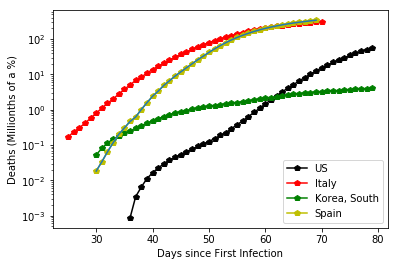

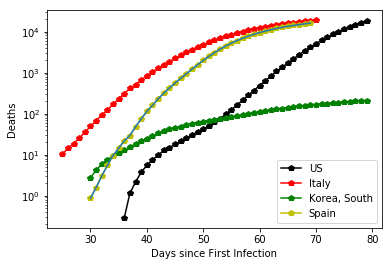

In [7]:
#del data6['Days until Cases Double (at this Rate)']
data6["Confirmed (Millionths of a %)"] = (10**6)*data6["Confirmed"]/data6["Population"]
data6["Recovered (Millionths of a %)"] = (10**6)*data6["Recovered"]/data6["Population"]
data6["Deaths (Millionths of a %)"] = (10**6)*data6["Deaths"]/data6["Population"]
data6["Active (Millionths of a %)"] = (10**6)*data6["Active"]/data6["Population"]
data6["New Cases (Millionths of a %)"] = (10**6)*data6["New Cases"]/data6["Population"]
#data6
#plotDataNumpy(data6, "New Cases", "Confirmed", True, True, win = 7)
#plotDataNumpy(data6, "New Cases (Millionths of a %)", "Confirmed (Millionths of a %)", True, True, win = 7)
plotDataNumpy(data6, "Deaths (Millionths of a %)", "Days since First Infection", True, False, win = 7)
plotDataNumpy(data6, "Deaths", "Days since First Infection", True, False, win = 7)
data6

In [187]:
def removeNonLetters(word):
    if type(word)==str:
        letters = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z".split(" ")
        letters.append(" ")
        ret = ""
        for i in word:
            if i in letters:
                ret+=i
        return ret
    else:
        return word

state_pop = pandas.read_excel("C:\\Sparsh Johri 2019\\nst-est2019-02.xlsx", header = 2)
state_pop = (state_pop[["Unnamed: 2", ".Geographic Area"]].rename(columns = {"Unnamed: 2":"Population", ".Geographic Area":"State"})
       .iloc[7:-7]).dropna()

state_pop["State"] = state_pop["State"].apply(removeNonLetters)
state_pop = state_pop.set_index("State")
state_pop.loc["California"]

Population    39512223
Name: California, dtype: object

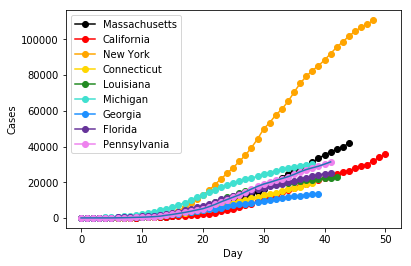

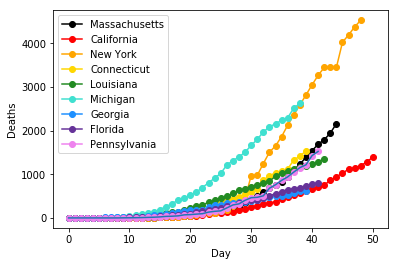

In [200]:
state_info = pandas.read_csv(states_path)
state_info = state_info.drop(columns = [state_info.columns[0]])

states = []
for i in state_info["County, State"]:
    states.append( i.split(",")[1][1:]  )
state_info["State"] = states

c = pandas.DataFrame()

for i in range(len(set(state_info["State"]))):
    b = (list(state_info.groupby("State"))[i][1].groupby("Date").
         agg({"Cases":numpy.sum, "Deaths":numpy.sum, "Population":numpy.sum})
         .reset_index().reset_index().rename(columns = {"index":"Day"}))
    a = list(state_info.groupby("State"))[i][0]
    b["State"] = a
    b["Population"] = state_pop.loc[a]["Population"]
    c = c.append(b)
#c = c.rename(columns = {"State":"Country/Region"})

def plotDataNumpyBetter(data, legend ,y_axis, x_axis, ylog_scale = False, xlog_scale = False,\
                        colors = "black red orange gold forestgreen turquoise dodgerblue rebeccapurple violet lightpink".split(), win = 7):
    data4 = data
    fig, ax = plt.subplots()
    #log scales
    if ylog_scale == True:
        plt.yscale("log")
    if xlog_scale == True:
        plt.xscale("log")
    #making a legend where each country is a different color
    place = 0
    for i in set(data4[legend]):
        data5 = data4[data4[legend]==i]
        y = data5[y_axis]
        x = data5[x_axis]
        ax.plot(x, y, color = colors[place], marker = "o", label=i)
        place += 1
    plt.legend()
    #adding labels
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    #plotting
    plt.plot(x, y)

plotDataNumpyBetter(c, "State", "Cases", "Day", False, False, win = 7)
plotDataNumpyBetter(c, "State", "Deaths", "Day", False, False, win = 7)
state_info = c
state_info["Cases (normalized)"] = state_info["Cases"]/state_info["Population"]
state_info["Deaths (normalized)"] = state_info["Deaths"]/state_info["Population"]